In [1]:
# If you want to run this on Google Colab, just uncomment the following lines. Please note,
# that you will need to locate your folder directly in the root directory of your Google Drive (/content/drive/My Drive/).
# Because otherwise, it won't work out of the box and you would need to adjust the path in here.
#
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#
#import os
#os.chdir("/content/drive/My Drive/CSMP-Project")

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from keras import layers

In [3]:
data_file = '../../../data/unNormMar1st.csv'

dataset = pd.read_csv(data_file, sep=';')

dataset

,Size,lamdabR,lambdaS,gamma,rho,normPulloff
0,512,128,32,0.455834,4.18537,0.009895
1,1536,128,64,0.435573,1.67609,0.000039
2,1536,512,16,0.005227,3.18212,0.000133
3,1280,64,32,0.177285,3.76808,0.022324
4,2048,256,16,0.076352,2.98880,0.000205
...,...,...,...,...,...,...
244,768,768,96,0.727092,4.59056,0.001356
245,2048,512,8,0.483503,1.77412,0.000047
246,2048,128,8,0.357011,2.82643,0.019321
247,768,192,4,0.017707,3.95707,0.010177


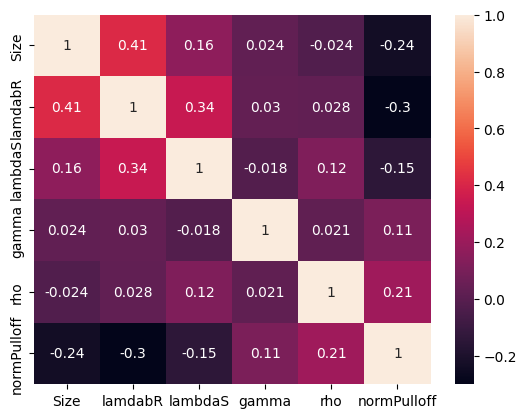

In [4]:
dataplot = sns.heatmap(dataset.corr(), cmap="rocket", annot=True)

plt.show()

In [5]:
dataset.describe()

,Size,lamdabR,lambdaS,gamma,rho,normPulloff
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,1255.325301,509.172691,95.052209,0.465411,2.633756,0.018394
std,532.167141,538.768225,197.670142,0.295416,1.309125,0.050093
min,256.000000,32.000000,4.000000,0.005227,0.125262,0.000003
25%,768.000000,128.000000,8.000000,0.201106,1.637750,0.000210
50%,1280.000000,256.000000,32.000000,0.446783,2.613690,0.000628
75%,1792.000000,768.000000,112.000000,0.716534,3.703470,0.002929
max,2048.000000,2048.000000,2048.000000,0.991867,4.993650,0.357983


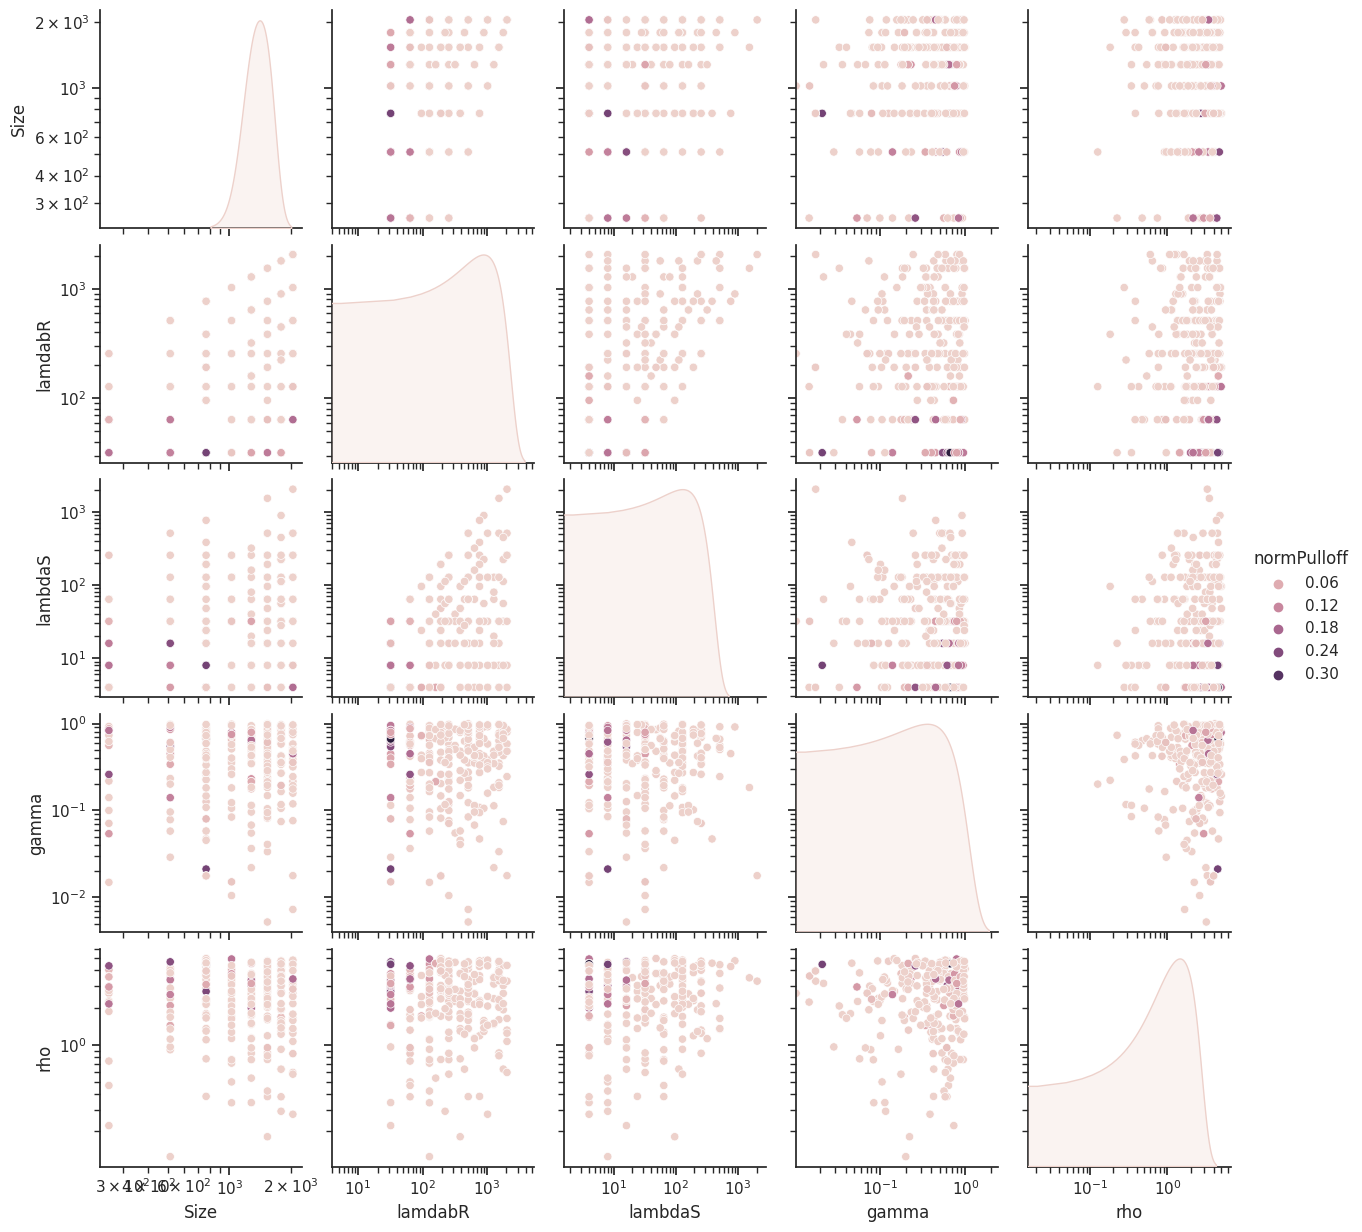

In [6]:
sns.set_theme(style="ticks")
pl = sns.pairplot(dataset, hue='normPulloff')

for ax in pl.axes.flat:
    ax.set(xscale='log')
    ax.set(yscale='log')

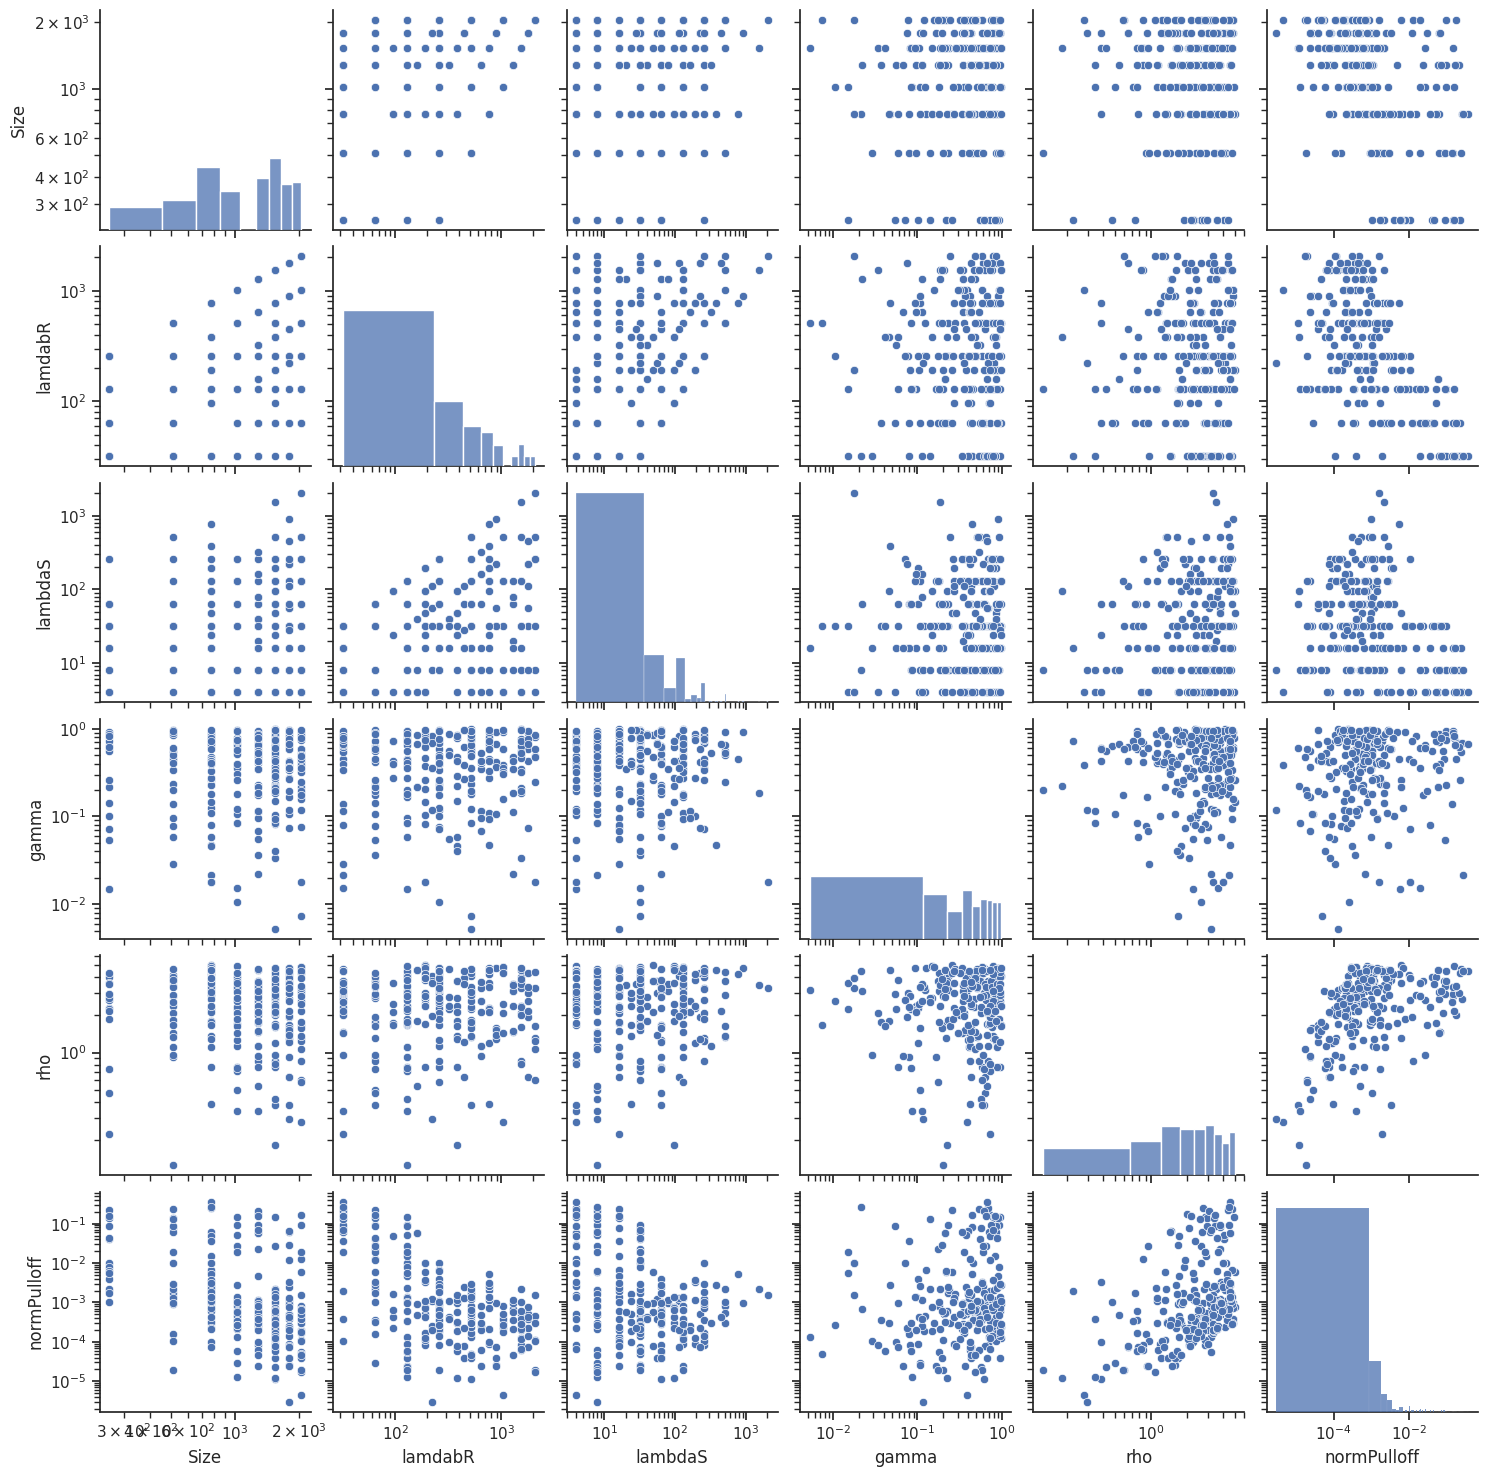

In [6]:
sns.set_theme(style="ticks")
pl = sns.pairplot(dataset)

for ax in pl.axes.flat:
    ax.set(xscale='log')
    ax.set(yscale='log')

In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=10)
test_dataset = dataset.drop(train_dataset.index)

test_dataset.sort_values('gamma', inplace=True)

len(train_dataset)

199

In [8]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = list(train_features.pop('normPulloff'))
test_labels = list(test_features.pop('normPulloff'))

In [9]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

rng = np.random.RandomState()

ada_regr = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=12), n_estimators=300, learning_rate=.2 , loss='linear', random_state=rng
)

ada_regr.fit(train_dataset.drop(['normPulloff'], axis=1), train_labels)

preds = ada_regr.predict(test_dataset.drop(['normPulloff'], axis=1))

# The mean squared error
mse = mean_squared_error(test_dataset['normPulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['normPulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['normPulloff'], preds))

Mean squared error: 0.0009083895
Root Mean squared error: 0.0301395002
Mean absolute error: 0.0132605958
Coefficient of determination: 0.74238


[]

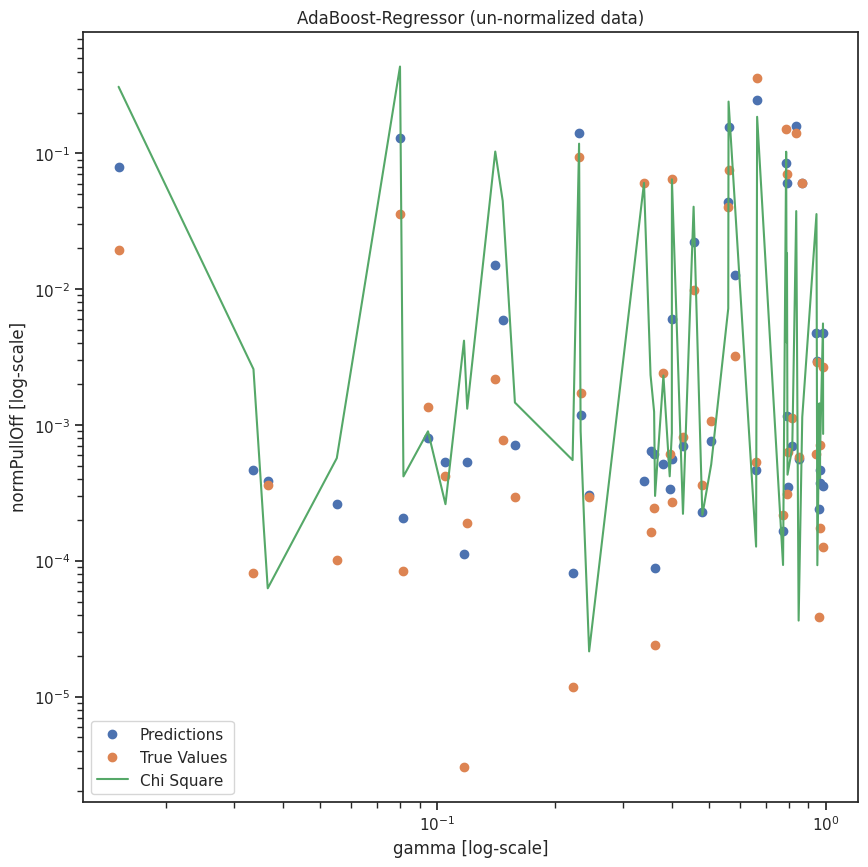

In [10]:
chi = list()

for i in range(len(test_labels)):
    curr = abs(test_labels[i]**2 - preds[i]**2) / test_labels[i]
    chi.append(curr)

plt.figure(figsize=(10,10))
a = plt.axes()
plt.plot(test_features["gamma"], preds, 'o', label='Predictions')
plt.plot(test_features["gamma"], test_labels, 'o', label='True Values')
plt.plot(test_dataset['gamma'], chi, label='Chi Square')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("AdaBoost-Regressor (un-normalized data)")
plt.xlabel('gamma [log-scale]')
plt.ylabel('normPullOff [log-scale]')
plt.plot()

In [11]:
from sklearn.ensemble import RandomForestRegressor

randForestReg = RandomForestRegressor(n_estimators=200, criterion="squared_error")
randForestReg.fit(train_dataset.drop(['normPulloff'], axis=1), train_labels)

preds = randForestReg.predict(test_dataset.drop(['normPulloff'], axis=1))

# The mean squared error
mse = mean_squared_error(test_dataset['normPulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['normPulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['normPulloff'], preds))

Mean squared error: 0.0010089689
Root Mean squared error: 0.0317642715
Mean absolute error: 0.0142283422
Coefficient of determination: 0.71386


[]

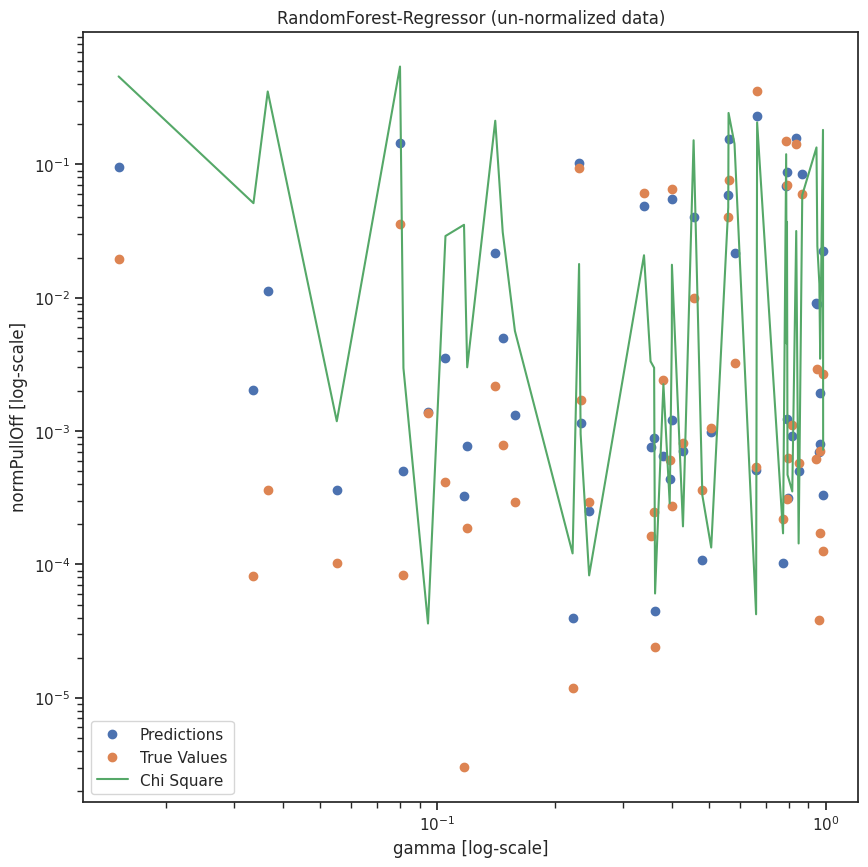

In [12]:
chi = list()

for i in range(len(test_labels)):
    curr = abs(test_labels[i]**2 - preds[i]**2) / test_labels[i]
    chi.append(curr)

plt.figure(figsize=(10,10))
a = plt.axes()
plt.plot(test_features["gamma"], preds, 'o', label='Predictions')
plt.plot(test_features["gamma"], test_labels, 'o', label='True Values')
plt.plot(test_dataset['gamma'], chi, label='Chi Square')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("RandomForest-Regressor (un-normalized data)")
plt.xlabel('gamma [log-scale]')
plt.ylabel('normPullOff [log-scale]')
plt.plot()

In [13]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors=7, weights='distance', p=2)
knn_reg.fit(train_dataset.drop(['normPulloff'], axis=1), train_labels)

preds = knn_reg.predict(test_dataset.drop(['normPulloff'], axis=1))

# The mean squared error
mse = mean_squared_error(test_dataset['normPulloff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['normPulloff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['normPulloff'], preds))

Mean squared error: 0.0016263190
Root Mean squared error: 0.0403276451
Mean absolute error: 0.0191787000
Coefficient of determination: 0.53878


[]

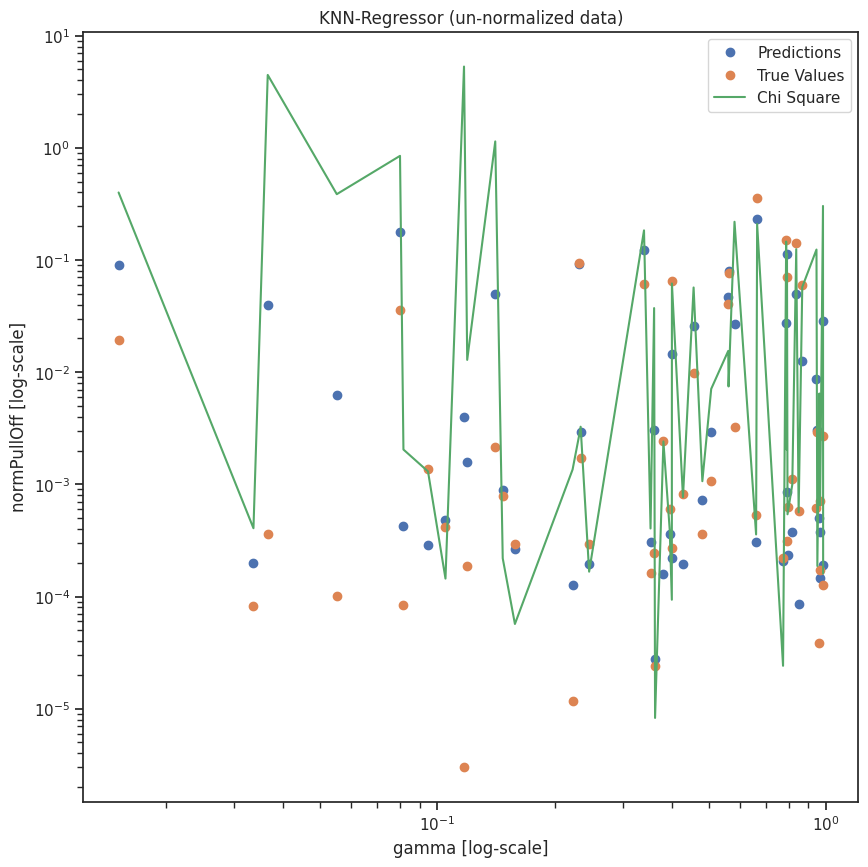

In [14]:
chi = list()

for i in range(len(test_labels)):
    curr = abs(test_labels[i]**2 - preds[i]**2) / test_labels[i]
    chi.append(curr)

plt.figure(figsize=(10,10))
a = plt.axes()
plt.plot(test_features["gamma"], preds, 'o', label='Predictions')
plt.plot(test_features["gamma"], test_labels, 'o', label='True Values')
plt.plot(test_dataset['gamma'], chi, label='Chi Square')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("KNN-Regressor (un-normalized data)")
plt.xlabel('gamma [log-scale]')
plt.ylabel('normPullOff [log-scale]')
plt.plot()

In [15]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Size,1241.407035,532.122518
lamdabR,530.974874,552.012438
lambdaS,99.859296,214.025912
gamma,0.461425,0.289244
rho,2.609405,1.311725
normPulloff,0.016934,0.047349


In [16]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

2023-03-02 08:51:56.226552: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/marc/Studium/WS22-23/Database Systems/dbsys22/build/debug/mutable/src/Mutable/lib:/usr/local/boost_1_80_0/stage/lib
2023-03-02 08:51:56.226727: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-02 08:51:56.226800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Marc-HP): /proc/driver/nvidia/version does not exist
2023-03-02 08:51:56.227586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other oper

[[1.2414070e+03 5.3097491e+02 9.9859299e+01 4.6142453e-01 2.6094050e+00]]


In [17]:
def loss(y_true, y_pred):
  #mse = keras.losses.mean_squared_error(y_true, y_pred)
  mae = keras.losses.mean_absolute_error(y_true, y_pred)
  return mae

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32),
      layers.LayerNormalization(),
      layers.Dropout(0.5),
      layers.ReLU(),
      layers.Dense(64),
      layers.LayerNormalization(),
      layers.Dropout(0.5),
      layers.ReLU(),
      layers.Dense(64),
      layers.LayerNormalization(),
      layers.Dropout(0.5),
      layers.ReLU(),
      layers.Dense(1)
  ])

  model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(1e-2))
  return model

In [18]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                192       
                                                                 
 layer_normalization (LayerN  (None, 32)               64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2

In [19]:
batch_size = len(train_dataset) - (int) (len(train_dataset) * 0.2)

history = dnn_model.fit(
    train_features,
    pd.DataFrame(train_labels),
    batch_size=batch_size,
    validation_split=0.2,
    epochs=2000)

Epoch 1/2000
1/1 [==============================] - 2s 2s/step - loss: 1.2317 - val_loss: 1.4247
Epoch 2/2000
1/1 [==============================] - 0s 47ms/step - loss: 1.1755 - val_loss: 1.1579
Epoch 3/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.9313 - val_loss: 0.4946
Epoch 4/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.7143 - val_loss: 0.2036
Epoch 5/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.6254 - val_loss: 0.3811
Epoch 6/2000
1/1 [==============================] - 0s 54ms/step - loss: 0.5741 - val_loss: 0.3391
Epoch 7/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.4934 - val_loss: 0.1102
Epoch 8/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.4234 - val_loss: 0.2010
Epoch 9/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.3634 - val_loss: 0.3063
Epoch 10/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.3483 - val_loss: 0.3582
Epoch 11/20

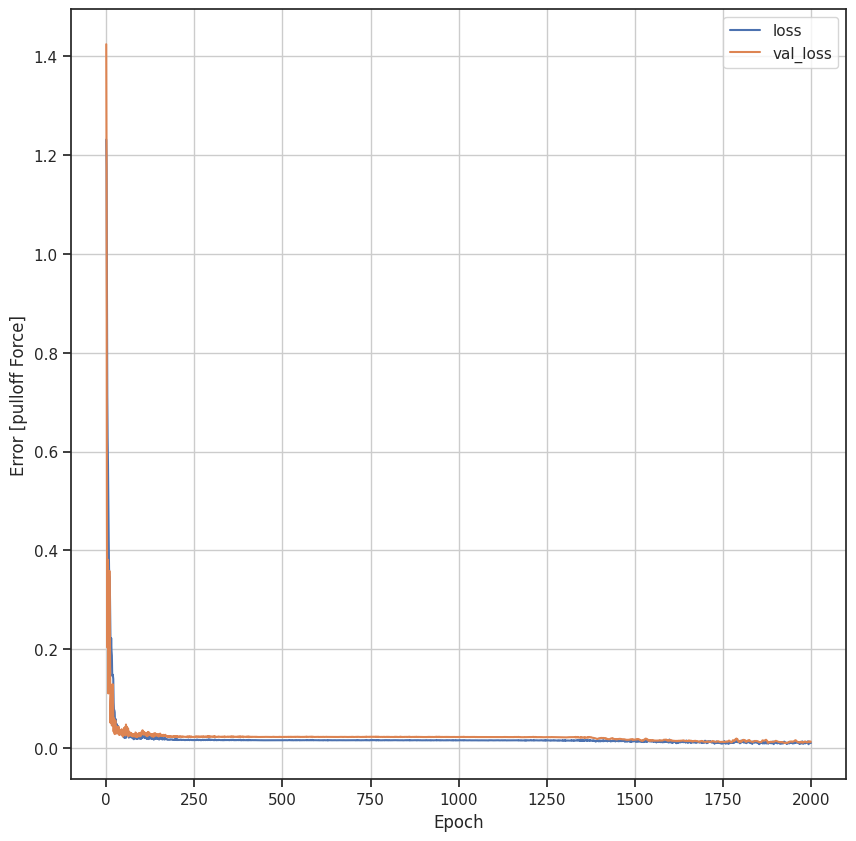

In [20]:
def plot_loss(history):
  plt.figure(figsize=(10,10))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [pulloff Force]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

2/2 [==============================] - 0s 5ms/step


[]

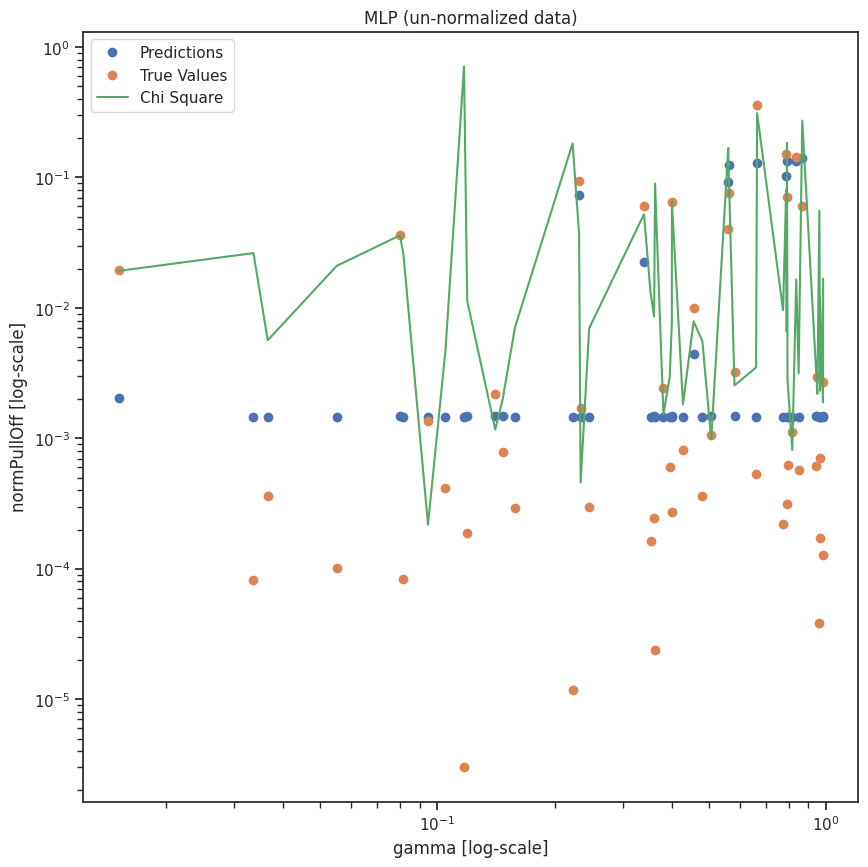

In [21]:
test_predictions = dnn_model.predict(test_features).flatten()

chi = list()

for i in range(len(test_labels)):
    curr = abs(test_labels[i]**2 - test_predictions[i]**2) / test_labels[i]
    chi.append(curr)

plt.figure(figsize=(10,10))
a = plt.axes()
plt.plot(test_features["gamma"], test_predictions, 'o', label='Predictions')
plt.plot(test_features["gamma"], test_labels, 'o', label='True Values')
plt.plot(test_dataset['gamma'], chi, label='Chi Square')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("MLP (un-normalized data)")
plt.xlabel('gamma [log-scale]')
plt.ylabel('normPullOff [log-scale]')
plt.plot()

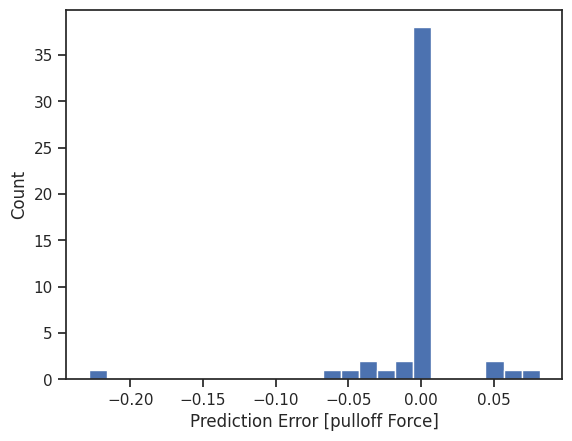

In [22]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [pulloff Force]')
_ = plt.ylabel('Count')

In [23]:
test_rsme = tf.math.sqrt(keras.losses.mean_squared_error(test_labels, test_predictions))
test_rsme.numpy()

0.039395723

In [ ]:
dnn_model.save('dnn_model')